# Multi-layer Perceptron

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
def Generar_train_test_sets():
    train = np.array([])
    test = np.array([])
    for i in range(k):
        if i in tt:
            if len(test) == 0:
                test = folds[i]
            else:
                test = np.concatenate((test,folds[i]))
        else:
            if len(train) == 0:
                train = folds[i]
            else:
                train = np.concatenate((train,folds[i]))
    return train, test

In [86]:
def Leer_Datos(name, delmt = '\t',head = None):
    data = pd.read_csv(name + '.csv', delimiter = delmt)
    return data

files = ["diabetes","Enfermedad_Cardiaca","iris"]
f = 1
data = Leer_Datos(files[f],'\t')
data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [87]:
data = data.sort_values(by=data.columns[-1])
raw_data = data.values
raw_data_x = raw_data[:,:-1]
raw_data_yl = raw_data[:,-1]
labels =[raw_data_yl[0]]
for ll in raw_data_yl:
    if ll not in labels:
        labels.append(ll)
raw_data_y = np.zeros((len(raw_data_x),len(labels)),dtype=bool)


In [88]:
i = 0
for la in raw_data_yl:
    raw_data_y[i,labels.index(la)] = 1
    i+=1
raw_data_y[-1]

array([False,  True])

In [89]:
raw_data_x = np.array(raw_data_x,dtype=np.float64)
def Normalizar_Datos(arraynp):
#     last = np.array(arraynp[:,-1])
    mean = np.mean(arraynp,0)
    standard = np.std(arraynp,0)
    for i in range(0,arraynp.shape[0]):
        arraynp[i] = np.true_divide((arraynp[i] - mean), standard)
#     arraynp[:,-1] = last[:]
    return arraynp

standard = np.std(raw_data_x,0)
raw_data_x = Normalizar_Datos(raw_data_x)

In [90]:
def Crear_k_folds(data, k =3, classes=2):
    indexs=[]
    for i in range(1,classes+1):
        ind = np.where(np.diff(data[:,-i]))
        for i in ind[0]:
            if i not in indexs:
                indexs.append(i)
    
    indexs= [x+1 for x in indexs]
    indexs.sort()
    print (indexs)
    Groups = np.split(data, indexs)
    
    Parts =[]
    for g in Groups:
        tmp = np.array_split(g, k)
        for p in tmp:
            Parts.append(p)
    
    res = list()
    for i in range(k):
        temp = Parts[i]
        for j in range(1,classes):
            temp = np.concatenate((temp,Parts[i+(k*j)]))

        np.random.shuffle(temp)
        res.append(temp)
    print('rr',len(res))
    return res

# raw_data_x = Normalizar_Datos(raw_data_x)
print(raw_data_x.shape,raw_data_y.shape)
print (raw_data_y[-1])
num_classes = len(raw_data_y[0])
raw_data = np.concatenate((raw_data_x,raw_data_y),axis=1)
print(raw_data.shape)
raw_folds = Crear_k_folds(raw_data,classes=num_classes)

(303, 13) (303, 2)
[False  True]
(303, 15)
[138]
rr 3


In [91]:
def Save_Folds(folds, name, file='/', delt='\t', classes=2):
    for i in range(len(folds)):
        X = folds[i][:,:-(classes)]
        Y = folds[i][:,-(classes):]
        xname = file + name + '_X' + str(i+1) + '.csv'
        yname = file + name + '_Y' + str(i+1) + '.csv'
        np.savetxt(xname, X, delimiter=delt)
        np.savetxt(yname, Y, delimiter=delt)
        
Save_Folds(raw_folds,'enf_cardiaca','folds/',',',num_classes)

In [2]:
def Sigmoidal(x):
    return 1.0 / (1+np.exp(-x))

def Derivada_Sigmoidal(x):
    return x * (1.0 - x)

def Calcular_Funcion_Costo(y_p, y):
    a = -np.log(y_p)
#     print ('a',a)
    b = a * y
#     print ('b',b)
#     loss = b.sum(axis=1).mean()
    loss = b.mean()
    return loss

def Calcular_Accuracy(X, Y, W):
    y_predict = Sigmoidal(X, W).round()#np.rint(Sigmoidal(X, Theta))
    count = 0
    for y in (Y-y_predict):
        if 1 not in y:
            count = count + 1
    return (count/len(Y)) * 100

In [3]:
def Forward(X, weights, activations):
    A = X
    activations[0] = A
    for i,w in enumerate(weights):
        h = np.dot(A, w)
        A = Sigmoidal(h)
        activations[i+1] = A
    return A, activations

def Backward(y_p, y, activations, weights, learning):
    delta = (y_p - y) * Derivada_Sigmoidal(activations[-1])
    for i in range(1,len(weights)+1):
        a = activations[-i-1].reshape(activations[-i-1].shape[0],-1)
        d = delta.reshape(delta.shape[0],-1).T
        weights[-i] -= learning *(np.dot(a,d))#/bach_size
        dd = Derivada_Sigmoidal(activations[-i-1])
        delta = dd * np.dot(delta,weights[-i].T)
    return weights
         
def Gradiente_Descendiente(X, Y, weights, iteraciones, learning, activations):
    costos = [0] * iteraciones
    for i in range(iteraciones):
        cost = 0
        for j,x in enumerate(X):
            y_p, activation = Forward(x, weights, activations)
            cost += Calcular_Funcion_Costo(y_p,Y[j])
            weights = Backward(y_p, Y[j], activations, weights, learning)
        costos[i] = cost / (len(X))
    return weights, costos

In [4]:
def Generar_Pesos(layers):
    wei = []
    for l in range(len(layers)-1):
        w = np.random.rand(layers[l],layers[l+1])
        wei.append(w)
    return wei

def Generar_Activaciones(layers):
    act = []
    for l in range(len(layers)):
        a = np.zeros(layers[l])
        act.append(a)
    return act

In [71]:
from random import random
items = np.array([[random()/2 for _ in range(2)] for _ in range(1000)])
targets = np.array([[i[0] + i[1]] for i in items])
# targets = np.array([[i[0] + i[1],i[0] - i[1],i[2] * i[3]] for i in items])

In [111]:
layers = [items.shape[1]]+[5]+[targets.shape[1]]
print (layers)
weis = Generar_Pesos(layers)
actis = Generar_Activaciones(layers)

W,costoss = Gradiente_Descendiente(items,targets,weis,200,0.2,actis)

[2, 5, 1]


In [109]:
inpu = np.array([0.1,0.2])
out,_ = Forward(inpu,W,actis)
print(inpu,out)

[0.1 0.2] [0.28594068]


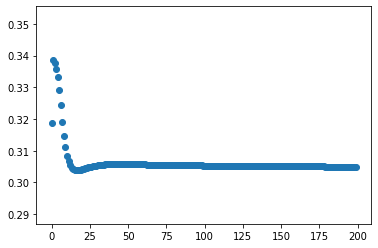

In [112]:
plt.scatter(np.arange(200),costoss)

In [220]:
fx1 = pd.read_csv("folds/iris_X1.csv",delimiter=',',header=None)
fx2 = pd.read_csv("folds/iris_X2.csv",delimiter=',',header=None)
fx3 = pd.read_csv("folds/iris_X3.csv",delimiter=',',header=None)
fy1 = pd.read_csv("folds/iris_Y1.csv",delimiter=',',header=None)
fy2 = pd.read_csv("folds/iris_Y2.csv",delimiter=',',header=None)
fy3 = pd.read_csv("folds/iris_Y3.csv",delimiter=',',header=None)

In [221]:
fxt = np.concatenate((fx1.values,fx2.values))
fyt = np.concatenate((fy1.values,fy2.values))

In [251]:
# 0.005, 300, [4, 3, 6, 3]
layers = [fxt.shape[1]]+[5,4]+[fyt.shape[1]]
print (layers)
weis = Generar_Pesos(layers)
# for e in weis:
#     print(e.shape)
actis = Generar_Activaciones(layers)
# for e in actis:
#     print(e.shape)
W,costoss = Gradiente_Descendiente(fxt,fyt,weis,300,0.4,actis)

[4, 5, 4, 3]


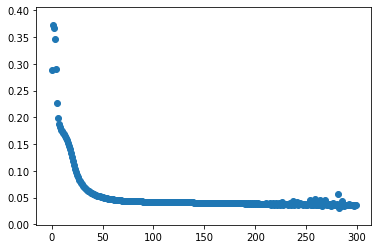

In [252]:
plt.scatter(np.arange(300),costoss)

In [5]:
def Calcular_Accuracy(X, Y, W, A):
    count = 0
    for i,x in enumerate(X):
        y_predict,_ = Forward(x,W,A)
        y_predict = np.around(y_predict)
        yy = Y[i]
        y = y_predict - yy
#         print (i,y_predict,yy,y)
        cc = y_predict == yy
#         print(cc,cc.all())
        if (y_predict == yy).all():
            count+=1
#         if np.all(y_predict==y):
#             count +=1
#     print(count,len(Y))
    return (count/len(Y)) * 100

In [253]:
Calcular_Accuracy(fx3.values,fy3.values,W,actis)

0 [0. 1. 0.] [0. 1. 0.] [0. 0. 0.]
1 [1. 0. 0.] [1. 0. 0.] [0. 0. 0.]
2 [1. 0. 0.] [1. 0. 0.] [0. 0. 0.]
3 [0. 0. 1.] [0. 0. 1.] [0. 0. 0.]
4 [0. 0. 1.] [0. 0. 1.] [0. 0. 0.]
5 [0. 1. 0.] [0. 1. 0.] [0. 0. 0.]
6 [0. 1. 0.] [0. 0. 1.] [ 0.  1. -1.]
7 [0. 1. 0.] [0. 1. 0.] [0. 0. 0.]
8 [0. 1. 0.] [0. 1. 0.] [0. 0. 0.]
9 [0. 1. 0.] [0. 1. 0.] [0. 0. 0.]
10 [1. 0. 0.] [1. 0. 0.] [0. 0. 0.]
11 [0. 0. 1.] [0. 0. 1.] [0. 0. 0.]
12 [0. 1. 0.] [0. 1. 0.] [0. 0. 0.]
13 [1. 0. 0.] [1. 0. 0.] [0. 0. 0.]
14 [1. 0. 0.] [1. 0. 0.] [0. 0. 0.]
15 [1. 0. 0.] [1. 0. 0.] [0. 0. 0.]
16 [0. 1. 0.] [0. 1. 0.] [0. 0. 0.]
17 [0. 1. 0.] [0. 0. 1.] [ 0.  1. -1.]
18 [1. 0. 0.] [1. 0. 0.] [0. 0. 0.]
19 [0. 1. 0.] [0. 0. 1.] [ 0.  1. -1.]
20 [1. 0. 0.] [1. 0. 0.] [0. 0. 0.]
21 [0. 0. 1.] [0. 0. 1.] [0. 0. 0.]
22 [0. 1. 0.] [0. 1. 0.] [0. 0. 0.]
23 [1. 0. 0.] [1. 0. 0.] [0. 0. 0.]
24 [1. 0. 0.] [1. 0. 0.] [0. 0. 0.]
25 [0. 0. 1.] [0. 0. 1.] [0. 0. 0.]
26 [0. 0. 1.] [0. 0. 1.] [0. 0. 0.]
27 [0. 1. 0.] [0. 0. 1.] [ 0.

91.66666666666666

### Experimento 1

In [6]:
def Get_train_test_sets(name, orden=1, k=3, deli='\t'):
    train_X = np.array([])
    train_Y = np.array([])
    test_X = np.array([])
    test_Y = np.array([])
    for i in range(k):
        if i+1 == orden:
            test_X = pd.read_csv(name+'_X'+str(i+1)+'.csv').values
            test_Y = pd.read_csv(name+'_Y'+str(i+1)+'.csv').values
        else:
            tx = pd.read_csv(name+'_X'+str(i+1)+'.csv').values
            ty = pd.read_csv(name+'_Y'+str(i+1)+'.csv').values
            if train_X.shape[0] == 0:
                train_X = tx
                train_Y = ty
            else:
                train_X = np.concatenate((train_X,tx))
                train_Y = np.concatenate((train_Y,ty))
            
    return train_X, train_Y, test_X, test_Y

import random

def getNeurons(num_layers=1, neurons=[1]):
    lays = []
    for i in range(num_layers):
        lays.append(random.choice(neurons))
    return lays

In [7]:
num_folds = 3
num_hidden_layers = [1,2,3,4]
num_neurons_per_l = [3,4,5]
tasa_aprendisaje = [0.1,0.2,0.3, 0.4, 0.5]#, 0.05, 0.1, 0.2]
num_iteraciones = [200,300, 500, 1000, 2000]

In [8]:
nn = len(num_hidden_layers)*len(tasa_aprendisaje)*len(num_iteraciones)
namefold = 'folds/iris'
# train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, 1, k=num_folds, deli=',')
LLL = getNeurons(2,[4,3,2])
nn

100

In [9]:
accuracies = np.empty((nn,3),dtype=np.float32)
list_layers = []
acc_index=0
acc_max = 0
best_parameters = (0,0,[])
ma_iris = []
dma = []
for l in num_hidden_layers:
    lay = getNeurons(l,num_neurons_per_l)
    matrix_ac = np.random.rand(len(tasa_aprendisaje),len(num_iteraciones),num_folds)
    for k in range(num_folds):
        train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, k+1, k=num_folds, deli=',')
        layers = [train_X.shape[1]]+lay+[train_Y.shape[1]]
        for i,t in enumerate(tasa_aprendisaje):
            for j,itr in enumerate(num_iteraciones):
                weigths = Generar_Pesos(layers)
                activations = Generar_Activaciones(layers)
                new_Weigths, _ = Gradiente_Descendiente(train_X, train_Y, weigths, itr, t, activations)

                matrix_ac[i,j,k] = Calcular_Accuracy(test_X,test_Y,new_Weigths,activations)
    ma_iris.append((layers,np.mean(matrix_ac,axis=2)))
#     dma.append(pd.DataFrame(data = ma[-1], index= tasa_aprendisaje, columns = num_iteraciones))
    print('========',layers,'========')
# print(ma)

======== [4, 3, 3] ========
======== [4, 4, 3, 3] ========
======== [4, 5, 4, 3, 3] ========
======== [4, 5, 4, 3, 5, 3] ========


In [12]:
ma

[([4, 4, 3], array([[85.78723404, 85.82978723],
         [87.16312057, 93.95744681],
         [93.29078014, 95.33333333]])),
 ([4, 4, 5, 3], array([[86.36879433, 96.66666667],
         [97.33333333, 96.66666667],
         [96.66666667, 96.62411348]]))]

In [24]:
max_acc = 0
parametrs = (0,0,[])

for ar,M in ma_iris:
    for i in range(len(M)):
        for j in range(len(M[0])):
            if M[i,j] > max_acc:
                max_acc = M[i,j]
                parametrs = (tasa_aprendisaje[i],num_iteraciones[j],ar)
                MM_ = M

print (parametrs,max_acc)

(0.1, 1000, [4, 4, 3, 3]) 98.0


In [25]:
df1 = pd.DataFrame(data = MM_, index= tasa_aprendisaje, columns = num_iteraciones)
df1

,200,300,500,1000,2000
0.1,87.290780,94.539007,95.957447,98.000000,96.666667
0.2,97.333333,97.333333,97.333333,95.957447,97.290780
0.3,97.333333,97.333333,95.872340,98.000000,93.787234
0.4,98.000000,96.666667,93.787234,93.787234,93.744681
0.5,95.333333,96.000000,93.120567,95.205674,94.539007


In [13]:
num_folds = 3
num_hidden_layers = [1,2,3,4]
num_neurons_per_l = [4,5,6,7]
tasa_aprendisaje = [0.1,0.2,0.3, 0.4, 0.5]#, 0.05, 0.1, 0.2]
num_iteraciones = [200,300, 500, 1000, 2000]

In [14]:
nn = len(num_hidden_layers)*len(tasa_aprendisaje)*len(num_iteraciones)
namefold = 'folds/enf_cardiaca'
# train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, 1, k=num_folds, deli=',')
LLL = getNeurons(2,[4,3,2])
nn

100

In [15]:
accuracies = np.empty((nn,3),dtype=np.float32)
list_layers = []
acc_index=0
acc_max = 0
best_parameters = (0,0,[])
ma_card = []
dma = []
for l in num_hidden_layers:
    lay = getNeurons(l,num_neurons_per_l)
    matrix_ac = np.random.rand(len(tasa_aprendisaje),len(num_iteraciones),num_folds)
    for k in range(num_folds):
        train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, k+1, k=num_folds, deli=',')
        layers = [train_X.shape[1]]+lay+[train_Y.shape[1]]
        for i,t in enumerate(tasa_aprendisaje):
            for j,itr in enumerate(num_iteraciones):
                weigths = Generar_Pesos(layers)
                activations = Generar_Activaciones(layers)
                new_Weigths, _ = Gradiente_Descendiente(train_X, train_Y, weigths, itr, t, activations)

                matrix_ac[i,j,k] = Calcular_Accuracy(test_X,test_Y,new_Weigths,activations)
    ma_card.append((layers,np.mean(matrix_ac,axis=2)))
#     dma.append(pd.DataFrame(data = ma[-1], index= tasa_aprendisaje, columns = num_iteraciones))
    print('========',layers,'========')
# print(ma)

======== [13, 5, 2] ========
======== [13, 7, 5, 2] ========
======== [13, 6, 4, 6, 2] ========
======== [13, 6, 5, 6, 7, 2] ========


In [26]:
max_acc = 0
parametrs = (0,0,[])
for ar,M in ma_card:
    for i in range(len(M)):
        for j in range(len(M[0])):
            if M[i,j] > max_acc:
                max_acc = M[i,j]
                parametrs = (tasa_aprendisaje[i],num_iteraciones[j],ar)
                MM_=M
print (parametrs, max_acc)

(0.1, 200, [13, 7, 5, 2]) 83.66666666666667


In [27]:
df2 = pd.DataFrame(data = MM_, index= tasa_aprendisaje, columns = num_iteraciones)
df2

,200,300,500,1000,2000
0.1,83.666667,81.000000,79.000000,80.666667,78.666667
0.2,80.333333,81.666667,76.666667,80.333333,77.666667
0.3,78.666667,80.000000,78.333333,78.666667,77.000000
0.4,79.666667,80.333333,79.666667,75.666667,76.333333
0.5,81.000000,77.000000,81.333333,77.000000,79.666667


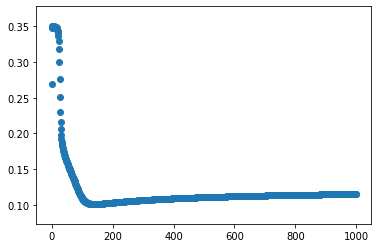

In [31]:
train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, k+1, k=num_folds, deli=',')
layers = [train_X.shape[1]]+[7,5]+[train_Y.shape[1]]
weigths = Generar_Pesos(layers)
activations = Generar_Activaciones(layers)
itera=1000
new_Weigths, loss = Gradiente_Descendiente(train_X, train_Y, weigths, itera, 0.1, activations)

plt.scatter(np.arange(itera),loss)

### Experimento 2

In [17]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [17]:
from sklearn import svm, datasets

iris = datasets.load_iris()
irisX = iris.data
irisy = iris.target
print(irisX.shape,irisy.shape)

(150, 4) (150,)


In [18]:
def toSVM(train, test):
#     print((train.shape[0],0))
    tr = np.zeros((train.shape[0],))
    ts = np.zeros((test.shape[0],))
#     print (tr.shape)
    
    for i,r in enumerate(train):
#         print(i,r,np.where(r==1)[0])
        tr[i] = np.where(r==1)[0]
    for i,s in enumerate(test):
        ts[i] = np.where(s==1)[0]
#     print (tr)
    return tr,ts

In [20]:
type_kernel = ['linear','poly','sigmoid','rbf']
parameter_C = [0.5,1.0,1.5,2.0,2.5,3.0,10.0]#[1.0,0.5,1.5]
matrix_ac_iris = np.random.rand(len(type_kernel),len(parameter_C),3)
namefold = 'folds/iris'
for k in range(num_folds):
    train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, k+1, k=num_folds, deli=',')
    train_Y, test_Y = toSVM(train_Y, test_Y)
#     print(train_Y)
    for i,ke in enumerate(type_kernel):
        for j,c in enumerate(parameter_C):
            clf = svm.SVC(C=c, kernel = ke)
#             print (train_X.shape,train_Y.shape)
            clf.fit(train_X, train_Y)
            matrix_ac_iris[i,j,k] = accuracy_score(test_Y,clf.predict(test_X))
        
matrix_ac_iris

C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

array([[[1.        , 0.9       , 1.        ],
        [0.98      , 0.92      , 1.        ],
        [0.98      , 0.9       , 1.        ],
        [1.        , 0.9       , 1.        ],
        [1.        , 0.9       , 1.        ],
        [1.        , 0.9       , 1.        ],
        [1.        , 0.92      , 1.        ]],

       [[0.88      , 0.88      , 0.89361702],
        [0.96      , 0.92      , 0.89361702],
        [0.98      , 0.94      , 0.91489362],
        [0.98      , 0.94      , 0.93617021],
        [0.98      , 0.94      , 0.93617021],
        [0.98      , 0.96      , 0.93617021],
        [0.98      , 0.92      , 0.95744681]],

       [[0.92      , 0.9       , 1.        ],
        [0.9       , 0.88      , 1.        ],
        [0.9       , 0.84      , 0.9787234 ],
        [0.84      , 0.78      , 0.9787234 ],
        [0.82      , 0.76      , 0.9787234 ],
        [0.8       , 0.76      , 0.9787234 ],
        [0.78      , 0.88      , 0.95744681]],

       [[0.96      , 0.92   

In [21]:
print(matrix_ac_iris.shape)
matrix_ac_iris = np.mean(matrix_ac_iris,axis=2)
parametros = (0,0)
for ta in  range(len(type_kernel)):
    for itr in range(len(parameter_C)):
        if(matrix_ac_iris[ta,itr] > matrix_ac_iris[parametros[0],parametros[1]]):
            parametros = (ta, itr)

df1 = pd.DataFrame(data = matrix_ac_iris, index= type_kernel, columns = parameter_C)
print("Mayor accuracy promedio con:",type_kernel[parametros[0]],parameter_C[parametros[1]])
df1

(4, 7, 3)
Mayor accuracy promedio con: rbf 10.0


,0.5,1.0,1.5,2.0,2.5,3.0,10.0
linear,0.966667,0.966667,0.960000,0.966667,0.966667,0.966667,0.973333
poly,0.884539,0.924539,0.944965,0.952057,0.952057,0.958723,0.952482
sigmoid,0.940000,0.926667,0.906241,0.866241,0.852908,0.846241,0.872482
rbf,0.945816,0.966241,0.973333,0.966667,0.960000,0.959574,0.986667


In [22]:
type_kernel = ['linear','poly','sigmoid','rbf']
parameter_C = [0.5,1.0,1.5,2.0,2.5,3.0,10.0]#[1.0,0.5,1.5]
matrix_ac_card = np.random.rand(len(type_kernel),len(parameter_C),3)
namefold = 'folds/enf_cardiaca'
for k in range(num_folds):
    train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, k+1, k=num_folds, deli=',')
    train_Y, test_Y = toSVM(train_Y, test_Y)
#     print(train_Y)
    for i,ke in enumerate(type_kernel):
        for j,c in enumerate(parameter_C):
            clf = svm.SVC(C=c, kernel = ke)
#             print (train_X.shape,train_Y.shape)
            clf.fit(train_X, train_Y)
            matrix_ac_card[i,j,k] = accuracy_score(test_Y,clf.predict(test_X))
        
matrix_ac_card

C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jhere\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

array([[[0.85, 0.83, 0.82],
        [0.85, 0.82, 0.81],
        [0.85, 0.82, 0.82],
        [0.85, 0.82, 0.82],
        [0.85, 0.82, 0.82],
        [0.85, 0.82, 0.82],
        [0.86, 0.83, 0.82]],

       [[0.77, 0.76, 0.77],
        [0.83, 0.8 , 0.8 ],
        [0.85, 0.79, 0.81],
        [0.86, 0.78, 0.8 ],
        [0.86, 0.8 , 0.79],
        [0.85, 0.81, 0.79],
        [0.81, 0.8 , 0.75]],

       [[0.82, 0.8 , 0.84],
        [0.84, 0.84, 0.82],
        [0.83, 0.82, 0.81],
        [0.84, 0.83, 0.83],
        [0.83, 0.84, 0.81],
        [0.84, 0.8 , 0.8 ],
        [0.82, 0.8 , 0.86]],

       [[0.87, 0.81, 0.84],
        [0.85, 0.84, 0.81],
        [0.84, 0.85, 0.83],
        [0.83, 0.85, 0.8 ],
        [0.83, 0.85, 0.79],
        [0.82, 0.83, 0.77],
        [0.8 , 0.8 , 0.77]]])

In [23]:
print(matrix_ac_card.shape)
matrix_ac_card = np.mean(matrix_ac_card,axis=2)
parametros = (0,0)
for ta in  range(len(type_kernel)):
    for itr in range(len(parameter_C)):
        if(matrix_ac_card[ta,itr] > matrix_ac_card[parametros[0],parametros[1]]):
            parametros = (ta, itr)

df1 = pd.DataFrame(data = matrix_ac_card, index= type_kernel, columns = parameter_C)
print("Mayor accuracy promedio con:",type_kernel[parametros[0]],parameter_C[parametros[1]])
df1

(4, 7, 3)
Mayor accuracy promedio con: rbf 0.5


,0.5,1.0,1.5,2.0,2.5,3.0,10.0
linear,0.833333,0.826667,0.830000,0.830000,0.830000,0.830000,0.836667
poly,0.766667,0.810000,0.816667,0.813333,0.816667,0.816667,0.786667
sigmoid,0.820000,0.833333,0.820000,0.833333,0.826667,0.813333,0.826667
rbf,0.840000,0.833333,0.840000,0.826667,0.823333,0.806667,0.790000


### Comparación entre SVM y MLP implementado